In [1]:
#导入需要使用的包
import numpy as np
import csv
import emoji
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
#emoji 操作相关的函数
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


emoji_dictionary = {"0": "\u2764\uFE0F",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)


def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))


def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):

    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)

    df_conf_norm = df_confusion / df_confusion.sum(axis=1)

    plt.matshow(df_confusion, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


def predict(X, Y, W, b, word_to_vec_map):
    m = X.shape[0]
    pred = np.zeros((m, 1))

    for j in range(m):  
        words = X[j].lower().split()
        avg = np.zeros((50,))
        for w in words:
            avg += word_to_vec_map[w]
        avg = avg/len(words)
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)

    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))

    return pred

In [4]:
#读入测试集/训练集
X_train, Y_train = read_csv('emoji/train_emoji.csv')
X_test, Y_test = read_csv('emoji/tesss.csv')
#获取X-train中最长的句子统计单词数目
maxLen = len(max(X_train, key=len).split())
#读入词向量表
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('emoji/glove.6B.50d.txt')

In [5]:
#将句子切分成单词，转换成index存入矩阵
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0] 
    X_indices = np.zeros((m, max_len))         

    for i in range(m):                          
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1
            
    return X_indices

In [6]:
#X_train demo
index = 1
print(X_train[index], label_to_emoji(Y_train[index]))

I am proud of your achievements 😄


In [7]:
#对表情进行one-hot编码
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [8]:
#one-hot编码后的demo
index = 50
print(Y_train[index], "is converted into one hot", Y_oh_train[index])

0 is converted into one hot [ 1.  0.  0.  0.  0.]


In [10]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[ 155345.  225122.       0.       0.       0.]
 [ 220930.  286375.   69714.       0.       0.]
 [ 151204.  192973.  302254.  151349.  394475.]]


In [11]:
#词向量表的demo
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [12]:
def sentence_to_avg(sentence, word_to_vec_map):
    #把所有的句子转换成小写 
    words = sentence.lower().split()
    #初始化word vector
    avg = np.zeros((50,))
    #计算 word vector的均值
    for w in words:
        #print(w,word_to_index[w])
        #print(word_to_vec_map[w])
        avg += word_to_vec_map[w]
    avg = avg/len(words)
    return avg

In [13]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


def get_weight(shape, regularizer):
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    if regularizer != None:
        tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(regularizer)(W))
    return W

def get_bias(shape):
    b = tf.Variable(tf.zeros(shape))
    return b
 
def forward(x, regularizer):
    n_y = 5
    n_h = 50
    W = get_weight([n_h, n_y], regularizer)
    b = get_bias([n_y,])
    #W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    #b = np.zeros((n_y,))
    avg = sentence_to_avg(x,word_to_vec_map)
    z = np.dot(W, avg) + b
    a = softmax(z)
    return a

def backward():
    n_y = 5
    n_h = 50
    x = tf.placeholder(tf.float32,  [None, n_h])
    y_ = tf.placeholder(tf.float32, [None, n_y])
    y = forward(x,REGULARIZER)
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_, 1))
    cem = tf.reduce_mean(ce)
    loss = cem + tf.add_n(tf.get_collection('losses'))
    
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE,#基础的学习率，随着迭代的进行，更新变量时使用的学习率在这个基础上递减
        global_step,#当前迭代的轮数
        train_num_examples / BATCH_SIZE, #过完所有的训练数据需要的轮次
        LEARNING_RATE_DECAY,#学习衰减率
        staircase=True)
    
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    #实例化滑动平均类
    ema = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
    #定义更新变量滑动平均的操作，在所有代表神经网络参数的变量上使用滑动平均
    ema_op = ema.apply(tf.trainable_variables())

    #将train_step和滑动平均计算ema_op放在train_op节点中
    with tf.control_dependencies([train_step, ema_op]):
        #tf.no_op()表示执行完 train_step, ema_op 操作之后什么都不做
        train_op = tf.no_op(name='train')

    #初始化持久化类
    saver = tf.train.Saver()

    img_batch, label_batch = generateds.get_batch(BATCH_SIZE,isTrain=True)

    with tf.Session() as sess:
        #初始化所有参数
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        for i in range(STEPS):
            #从训练集中抽取BATCH_SIZE个样本输入到神经网络
            xs, ys = sess.run([img_batch, label_batch])
            #计算train_op节点，包含train_step和ema_op，’_’表示后面不使用返回值中该位置的变量
            _, loss_value, step = sess.run([train_op, loss, global_step], feed_dict={x: xs, y_: ys})
            #输出当前的训练情况
            if i % 100 == 0:
                print("After %d training step(s), loss on training batch is %g." % (step, loss_value))
                #以指定路径保存模型
                saver.save(sess, os.path.join(MODEL_SAVE_PATH, MODEL_NAME), global_step=global_step)
        
        coord.request_stop()
        coord.join(threads)
            

import tensorflow as tf
BATCH_SIZE = 1
LEARNING_RATE_BASE = 0.1
LEARNING_RATE_DECAY = 0.99
REGULARIZER = 0.0001
STEPS = 400
MOVING_AVERAGE_DECAY = 0.99
MODEL_SAVE_PATH="./model/"
MODEL_NAME="mnist_model"
backward()

In [15]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    np.random.seed(1)
    m = Y.shape[0]                         
    n_y = 5                                
    n_h = 50                            
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    for t in range(num_iterations):                       
        for i in range(m):                                
            avg = sentence_to_avg(X[i], word_to_vec_map)
            #前向传播
            z = np.dot(W, avg) + b
            a = softmax(z)
            #计算loss
            cost = -np.sum(Y_oh[i] * np.log(a))
            #反向传播
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz
            #参数更新
            W = W - learning_rate * dW
            b = b - learning_rate * db

        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [16]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)


In [17]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.95204988128
Accuracy: 0.348484848485
Epoch: 100 --- cost = 0.0797181872601
Accuracy: 0.931818181818
Epoch: 200 --- cost = 0.0445636924368
Accuracy: 0.954545454545
Epoch: 300 --- cost = 0.0343226737879
Accuracy: 0.969696969697
[[ 3.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 4.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 0.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 4.]
 [ 3.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 4.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 4.]
 [ 4.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 2.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 4.]
 [ 0.]
 [ 0.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 2.]
 [ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 3.]
 [ 2.]
 [ 2.]
 [ 

In [18]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.977272727273
Test set:
Accuracy: 0.857142857143


In [19]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "you are not happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.833333333333

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
you are not happy ❤️


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


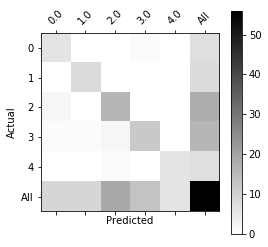

In [20]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)